In [1]:
import torch
import gc
torch.cuda.empty_cache()
gc.collect()

0

In [1]:
import numpy as np
from audiolm_pytorch import SoundStream, SoundStreamTrainer

soundstream = SoundStream(
    codebook_size = 1024,
    rq_num_quantizers = 8,
)
soundstream.load("content/soundstream/results3/soundstream.9000.pt")

trainer = SoundStreamTrainer(
    soundstream,
    folder = '/home/ckwdani/Music/train-clean-100',
    batch_size = 4,
    grad_accum_every = 8,         # effective batch size of 32
    data_max_length = 320 * 32,
    num_train_steps = 20,
    save_model_every=10,
    results_folder = './content/soundstream/results2',
).cuda()

trainer.train()



2023-01-16 17:02:00 | INFO | fairseq.tasks.text_to_speech | Please install tensorboardX: pip install tensorboardX
2023-01-16 17:02:00.183360: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-16 17:02:00.731543: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-01-16 17:02:00.731591: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-01-16 17:02:00.731596: W tensorflow/compiler/tf

RuntimeError: Error(s) in loading state_dict for SoundStream:
	Missing key(s) in state_dict: "stft_discriminator.stft.window". 
	Unexpected key(s) in state_dict: "stft_discriminator.layers.0.1.b", "stft_discriminator.layers.1.1.b", "stft_discriminator.layers.2.1.b", "stft_discriminator.layers.3.1.b", "stft_discriminator.layers.4.1.b", "stft_discriminator.layers.5.1.b". 
	size mismatch for stft_discriminator.init_conv.weight: copying a param with shape torch.Size([32, 1, 7, 7]) from checkpoint, the shape in current model is torch.Size([32, 2, 7, 7]).

In [7]:
#freeze soundstream parameters
for param in soundstream.parameters():
    param.requires_grad = False

In [11]:
from audiolm_pytorch import SoundStream, SoundStreamTrainer
soundstream = SoundStream(
    codebook_size = 2048,
    rq_num_quantizers = 8,
    #target_sample_hz=32000
)
soundstream.load("content/01_Soundstream_new_libri_100_test/2_libri_with360_10000/soundstream.0.pt")
soundstream.to("cuda")

for param in soundstream.parameters():
    param.requires_grad = False

In [12]:

from audiolm_pytorch.data import SoundDataset
import torchaudio




test = torchaudio.load("/home/ckwdani/Music/libri/libri_clean/train-clean-100/40/222/40-222-0000.flac")
testCafe = torchaudio.load("/home/ckwdani/Programming/Projects/masterarbeit/Datasets/CaFE_48k/Joie/Fort/01-J-2-1.wav")
#test = torchaudio.load("/home/ckwdani/Programming/Projects/masterarbeit/Jupyter/mainProject/Stimuli_Intensitätsmorphs/nf01_ang_w02_o_100_70dB.wav")

import torch
with torch.no_grad():

    testTensor = soundstream.encoder(test[0].to("cuda"))
    testForward = soundstream(test[0].to("cuda"),
                              return_encoded = True,
                              #return_recons_only=True
                              )
    testCafeForward = soundstream(testCafe[0].to("cuda"), return_encoded=True)



In [16]:
from IPython.lib.display import Audio
import numpy as np


#Audio(soundstream.decoder(testCafeForward[0]).detach().cpu().numpy()[0,0,:], rate=48000)
Audio(soundstream.decoder(testForward[0]).detach().cpu().numpy()[0,0,:], rate=48000)
#Audio(soundstream.decoder(testTensor.unsqueeze(0)).detach().cpu().numpy()[0,0,:], rate=16000)
#Audio(test[0].numpy(), rate=16000)

#Audio(test[0], rate=test[1])
#soundstream.decoder(testTensor).detach().cpu().numpy()[0,0,:]



#testForward[0].cpu().numpy()[0]
#soundstream.decoder(testForward[0]).detach().cpu().numpy()[0,0,:]
#testTensor.cpu().numpy()
#testForward[0].cpu().numpy()[0]

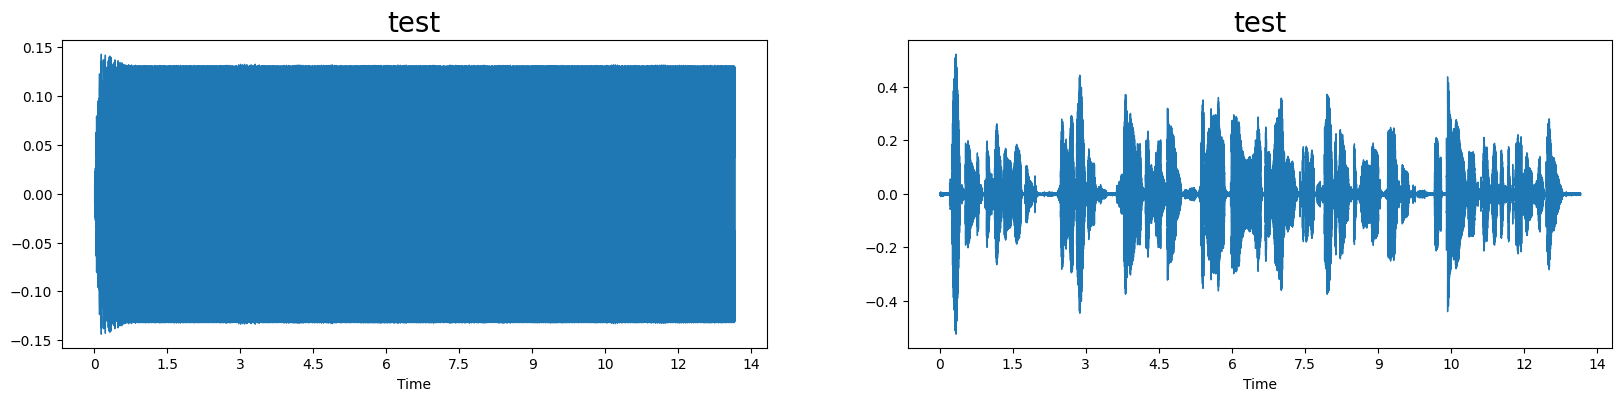

In [14]:
import sys
from pathlib import Path
import importlib
module_path = str(Path.cwd().parents[0] / "utils")

if module_path not in sys.path:
    sys.path.append(module_path)
import utils.exploratoryUtils as exU
importlib.reload(exU)

#exU.waveplot(soundstream.decoder(testTensor).detach().cpu().numpy(), sr=22050, emotion="test")
exU.waveplot_two_datas(soundstream.decoder(testTensor).detach().cpu().numpy(), sr=16000, emotion="test", data1=test[0].numpy(), sr1=16000, emotion1="test")
#exU.waveplot_two_datas(soundstream.decoder(testForward[0]).detach().cpu().numpy()[0,0,:], sr=16000, emotion="test", data1=test[0].numpy(), sr1=16000, emotion1="test")

In [8]:
import torch
with torch.no_grad():
    output = soundstream.encoder(test[0].to("cuda"))
nump = output.cpu().numpy()
numpMena = nump.mean(1)
# numpMena.shape = 1,512
import sklearn.decomposition as sk
pca = sk.PCA(n_components=3)

pca.fit_transform(nump.T - nump.T.mean())

array([[ 0.8432426 , -0.20598646,  0.06698824],
       [ 0.71345305, -0.9714332 ,  2.932274  ],
       [-0.22961353, -1.6630569 ,  1.0619271 ],
       ...,
       [-0.19929604, -0.5194261 ,  0.52550644],
       [ 0.14152002, -1.343442  , -0.01148824],
       [ 0.06970652, -1.0658243 ,  0.7267386 ]], dtype=float32)

## Loading dataset ##

In [9]:
 #Loading the created dataset using datasets
from datasets import load_dataset, load_metric


data_files = {
    "train": "train.csv",
    "validation": "test.csv",
    "testPersonal": "testPersonal.csv"

}

dataset = load_dataset("content/data/", data_files=data_files, delimiter="\t", )
train_dataset = dataset["train"]
eval_dataset = dataset["validation"]
testPersonal_dataset = dataset["testPersonal"]

# We need to specify the input and output column
input_column = "path"
output_column = "emotion"
# we need to distinguish the unique labels in our SER dataset
label_list = train_dataset.unique(output_column)
label_list.sort()  # Let's sort it for determinism
num_labels = len(label_list)
#print(f"A classification problem with {num_labels} classes: {label_list}")

2023-01-04 13:48:09 | WARNING | datasets.builder | Using custom data configuration data-5f9e506447fa6370
2023-01-04 13:48:09 | WARNING | datasets.builder | Found cached dataset csv (/home/ckwdani/.cache/huggingface/datasets/csv/data-5f9e506447fa6370/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317)


  0%|          | 0/3 [00:00<?, ?it/s]

## Preprocessing data with soundstream ##

In [11]:
import utils.audio_dataset_utils as audioUtils
import torchaudio
import pyarrow as pa
import numpy as np

def preprocess_function(example):

    speech = torchaudio.load(example[input_column])[0].to("cuda")
    target = audioUtils.label_to_id(example[output_column], label_list)

    audio_encoded = soundstream.encoder(speech).cpu().detach().numpy()
    audio_1d = pa.array([audio_encoded.flatten()])
    labels = pa.array([target])
    path = pa.array([example[input_column]])
    names = [input_column ,"audio", "labels"]

    result = pa.Table.from_arrays([path, audio_1d, labels], names=names)

    #result = soundstream.encoder(speech).cpu().detach().numpy()
    #result["labels"] = target
    return result


In [12]:
train_dataset = train_dataset.map(
    preprocess_function,
    num_proc=1
)

eval_dataset = eval_dataset.map(
    preprocess_function,
    num_proc=1
)

2023-01-04 12:41:42 | WARNING | datasets.arrow_dataset | Loading cached processed dataset at /home/ckwdani/.cache/huggingface/datasets/csv/data-5f9e506447fa6370/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317/cache-e9cf89ac3ff0b3e8.arrow
2023-01-04 12:41:43 | WARNING | datasets.arrow_dataset | Loading cached processed dataset at /home/ckwdani/.cache/huggingface/datasets/csv/data-5f9e506447fa6370/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317/cache-22c82ca8dddfd685.arrow


In [13]:
train_dataset[0]["audio"]

[0.30638760328292847,
 -0.30510470271110535,
 -0.33041197061538696,
 -0.2907174229621887,
 -0.3562255799770355,
 0.29445400834083557,
 -0.1566108763217926,
 -0.013954618945717812,
 0.20529910922050476,
 -0.27934232354164124,
 0.46071091294288635,
 -0.1593111753463745,
 -0.28406962752342224,
 -0.7017614841461182,
 4.427418231964111,
 4.227181911468506,
 6.26907205581665,
 3.013918876647949,
 0.8764342069625854,
 0.4706113636493683,
 -2.3540198802948,
 1.8373867273330688,
 0.6554034352302551,
 -2.4241299629211426,
 -5.201148509979248,
 -1.7195477485656738,
 0.6305285096168518,
 -1.0125614404678345,
 -0.6431014537811279,
 -0.7181299924850464,
 0.6639125347137451,
 -0.08849243819713593,
 4.775681018829346,
 2.1517083644866943,
 -3.295724391937256,
 3.406432628631592,
 -4.095615863800049,
 3.162663698196411,
 -2.231292724609375,
 3.5209290981292725,
 -0.4133601486682892,
 -0.1339941918849945,
 -0.12384411692619324,
 -0.31169384717941284,
 -0.1335468739271164,
 0.7801569104194641,
 1.2892788

In [14]:
import numpy as np
a = np.array([[0, 1, 2, 3],[4,5,6,7],[9,10,11,12], [13,14,15,16],[17,18,19,20]])
a[:][1:5]

array([[ 4,  5,  6,  7],
       [ 9, 10, 11, 12],
       [13, 14, 15, 16],
       [17, 18, 19, 20]])

In [10]:
from IPython.lib.display import Audio
import torch

unshaped =train_dataset[0]["audio"]
shaped = np.reshape(unshaped, (512, -1))
Audio(soundstream.decoder(torch.Tensor(shaped).to("cuda")).cpu().detach(), rate=16000)

KeyError: 'audio'

In [11]:
import utils.audio_dataset_utils as audioUtils
import torchaudio

trainList=[]
labelList=[]

for example in train_dataset:
    speech = torchaudio.load(example[input_column])[0].to("cuda")
    trainList.append(soundstream.encoder(speech).cpu().detach().numpy())
    labelList.append(audioUtils.label_to_id(example[output_column], label_list))
trainList

[array([[ 0.3063876 , -0.3051047 , -0.33041197, ..., -0.08234769,
         -0.06548929, -0.04923954],
        [-0.40830952, -0.08928604,  0.02311837, ..., -0.13858025,
         -0.17554885, -0.15426645],
        [ 0.08498046,  0.26603556, -0.05119919, ..., -0.17769513,
         -0.15309277, -0.21012864],
        ...,
        [-0.3203127 ,  0.30068865,  0.53593117, ...,  0.2162215 ,
          0.22546041,  0.20146024],
        [ 0.02693148, -0.08334566, -0.01004564, ..., -0.25506097,
         -0.27970195, -0.3014522 ],
        [-0.07455716, -0.16043043, -0.24871989, ..., -0.0863315 ,
         -0.07316703, -0.05220665]], dtype=float32),
 array([[ 0.30637044, -0.31880808, -0.33953336, ..., -0.06603552,
         -0.06749448, -0.07403287],
        [-0.40832615, -0.06253474, -0.0054084 , ..., -0.15713125,
         -0.1607995 , -0.15691672],
        [ 0.0849805 ,  0.26155242, -0.01608033, ..., -0.17956439,
         -0.19376016, -0.16338073],
        ...,
        [-0.32028994,  0.27833542,  0.3

## LSTM ##

In [12]:
import network_models.soundstream_lstm.lstm_model as soundStreamLSTM

num_epochs = 1000 #1000 epochs
learning_rate = 0.001 #0.001 lr

input_size = 512 #number of features
hidden_size = 2 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes

lstm1 = soundStreamLSTM.LSTM1(num_classes, input_size, hidden_size, num_layers, testTensor[:, 0].shape) #lstm class

In [13]:
criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm1.parameters(), lr=learning_rate)

In [41]:
for epoch in range(num_epochs):
  outputs = lstm1.forward(train_dataset)
      #X_train_tensors_final)
      # #forward pass
  optimizer.zero_grad() #caluclate the gradient, manually setting to 0

  # obtain the loss function
  loss = criterion(outputs, eval_dataset)
                   #y_train_tensors)

  loss.backward() #calculates the loss of the loss function

  optimizer.step() #improve from loss, i.e backprop
  if epoch % 100 == 0:
    print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

AttributeError: 'Dataset' object has no attribute 'size'

In [42]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Conv1D, Flatten, Activation, MaxPooling1D


def create_new_model(layer):
    model = Sequential([
        LSTM(123, return_sequences=False, input_shape=(layer)),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(6, activation='softmax')
    ])

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

In [43]:
layer = 512
model = create_new_model(layer=layer)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 512)               1052672   
                                                                 
 dense_3 (Dense)             (None, 64)                32832     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_5 (Dense)             (None, 6)                 198       
                                                                 
Total params: 1,087,782
Trainable params: 1,087,782
No

In [38]:
y_train_list = [np.array([x]) for x in labelList]

In [39]:
y_train_list

[array([2]),
 array([4]),
 array([0]),
 array([0]),
 array([1]),
 array([5]),
 array([3]),
 array([0]),
 array([3]),
 array([4]),
 array([4]),
 array([5]),
 array([5]),
 array([3]),
 array([5]),
 array([5]),
 array([1]),
 array([5]),
 array([1]),
 array([3]),
 array([5]),
 array([5]),
 array([5]),
 array([1]),
 array([0]),
 array([5]),
 array([1]),
 array([1]),
 array([1]),
 array([0]),
 array([2]),
 array([0]),
 array([1]),
 array([2]),
 array([3]),
 array([0]),
 array([2]),
 array([0]),
 array([3]),
 array([3]),
 array([3]),
 array([1]),
 array([2]),
 array([2]),
 array([3]),
 array([3]),
 array([0]),
 array([0]),
 array([1]),
 array([2]),
 array([3]),
 array([0]),
 array([1]),
 array([4]),
 array([3]),
 array([4]),
 array([5]),
 array([5]),
 array([4]),
 array([4]),
 array([2]),
 array([5]),
 array([5]),
 array([2]),
 array([3]),
 array([2]),
 array([2]),
 array([2]),
 array([2]),
 array([3]),
 array([4]),
 array([2]),
 array([5]),
 array([0]),
 array([4]),
 array([4]),
 array([5]),

In [35]:
y_train_list.shape

AttributeError: 'list' object has no attribute 'shape'

In [32]:
x_train = np.expand_dims(trainList, -1)

/home/ckwdani/Programming/Projects/masterarbeit/Jupyter/mainProject/venv/lib/python3.10/site-packages/numpy/lib/shape_base.py:591: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  a = asanyarray(a)


ValueError: could not broadcast input array from shape (512,134) into shape (512,)

In [40]:
epochs = 1
history = model.fit(trainList, y_train_list, epochs=epochs)

ValueError: Data cardinality is ambiguous:
  x sizes: 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512
  y sizes: 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1
Make sure all arrays contain the same number of samples.